In [7]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [8]:
!gpustat

iapetus                        Wed Jun 22 21:24:25 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[1] NVIDIA GeForce GTX 1080 Ti | 24'C,   0 % |     4 / 11178 MB |
[2] NVIDIA GeForce GTX 1080 Ti | 23'C,   0 % |     1 / 11178 MB |
[3] NVIDIA GeForce GTX 1080 Ti | 46'C,  10 % |  1580 / 11178 MB | blia(787M) blia(787M)
[4] NVIDIA GeForce GTX 1080 Ti | 46'C,   0 % |  1580 / 11178 MB | blia(787M) blia(787M)
[5] NVIDIA GeForce GTX 1080 Ti | 43'C,   0 % |  2307 / 11178 MB | blia(727M) blia(787M)
[6] NVIDIA GeForce GTX 1080 Ti | 39'C,   4 % |  1520 / 11178 MB | blia(787M) blia(727M)
[7] NVIDIA GeForce GTX 1080 Ti | 45'C,   1 % |  1578 / 11178 MB | blia(787M) blia(787M)


In [9]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [31]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy
from scipy import spatial

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [11]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [13]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [14]:
chart = [ [ ['1p', 'onlyBlosum', 20],  ['5p', 'onlyBlosum', 20], ['25p', 'onlyBlosum', 20], ['50p', 'onlyBlosum', 20], ['75p', 'onlyBlosum', 20], ['100p', 'onlyBlosum', 20]],
[ ['1p', 'onlyEmbedding', 4],  ['5p', 'onlyEmbedding', 4], ['25p', 'onlyEmbedding', 4], ['50p', 'onlyEmbedding', 4], ['75p', 'onlyEmbedding', 4], ['100p', 'onlyEmbedding', 4]],
[ ['1p', 'onlyEmbedding', 20],  ['5p', 'onlyEmbedding', 20], ['25p', 'onlyEmbedding', 20], ['50p', 'onlyEmbedding', 20], ['75p', 'onlyEmbedding', 20], ['100p', 'onlyEmbedding', 20]],    
[ ['1p', 'onlyEmbedding', 32],  ['5p', 'onlyEmbedding', 32], ['25p', 'onlyEmbedding', 32], ['50p', 'onlyEmbedding', 32], ['75p', 'onlyEmbedding', 32], ['100p', 'onlyEmbedding', 32]],
[ ['1p', 'onlyEmbedding', 64],  ['5p', 'onlyEmbedding', 64], ['25p', 'onlyEmbedding', 64], ['50p', 'onlyEmbedding', 64], ['75p', 'onlyEmbedding', 64], ['100p', 'onlyEmbedding', 64]]    ]


blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}


size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}


for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [15]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [35]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_info = chart[2][5]
size = model_info[0]   
model_type = model_info[1]
d_model = d_k = d_v = model_info[2]

model_abbr = 'FFNN'

print(size, model_type, d_model)

id_blosum = 'OF_TData_pad14_{}_{}_hlac'
id_emb = 'OF_TData_pad14_{}_{}'

save_attn = False

100p onlyEmbedding 20


SET PARAMETERS AND MODEL TO GET FIGURES

In [17]:
 if "Blosum" in model_type:
            id_nested = id_blosum.format(size, model_type)  
            encoding_ = 'blosum'
            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.pos_emb = PositionalEncoding(d_model)

                def forward(self, enc_inputs):
                    ##B## enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                    enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                    return enc_outputs, 0
            print("Transformer Blosum imported")
            
if "Embedding" in model_type:
            
            id_nested = id_emb.format(size, model_type)
            encoding_ = 'embedding'
            
            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.src_emb = nn.Embedding(vocab_size, d_model)
                    self.pos_emb = PositionalEncoding(d_model)

                def forward(self, enc_inputs):
                    enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]

                    #print("---------")
                    #print("---------")
                    #if len(enc_outputs[0]) == 14:
                    #    for i, t in zip(enc_inputs[0], enc_outputs[0]):
                    #        print("\'" + str(list(vocab.keys())[i.item()-1]) + "\':" , t.tolist())
                    #print("---------")
                    #print("---------")
                    #print("---------")

                    enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model
                    return enc_outputs, 0

            print("TransformerOnlyEmbedding imported")            
        
                
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device('cuda')
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)

    def forward(self, pep_inputs, hla_inputs, pep_to_pad):
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1)
        dec_outputs = enc_outputs.view(enc_outputs.shape[0], -1) 
        dec_logits = self.projection(dec_outputs) 
        return dec_logits.view(-1, dec_logits.size(-1)), 0, 0

TransformerOnlyEmbedding imported


TEST MODEL

In [18]:
auc_list = []
auc01_list = []
ppv_list = []

In [19]:
print('\n\n\n===== Model {}, {}, {} ====='.format(size,model_type,d_model))

ep_best = 0
fold = 0

test_fold_metrics_list_nested = []

fold_avg_4 = True
type_ = 'test'

df_list = []
time_testing = time.time()

if fold_avg_4:

    fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
    pred_all = []
    target_all = []
    enc_attn_list_all = []
    enc_hla_attn_list_all = []
    
    for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

            pred_fold = []
            target_fold = []
            enc_attn_list_tmp = []
            enc_hla_attn_list_tmp = []

            #print('\n=====Models-{}====='.format(fold_avg))

            for f in fold_avg:
                index_order_idx = f
                path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                    model_type, 
                                                                                                                    pep_max_len,
                                                                                                                    hla_max_len,
                                                                                                                    vocab,
                                                                                                                    index_order_idx, 
                                                                                                                    type_ = type_, 
                                                                                                                    fold = file_num,  
                                                                                                                    batch_size = batch_size)
                model = Transformer().to(device)

                model.load_state_dict(torch.load(path_saver))
                model_test = model.eval()

                ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda) # , test_res_attns
                pred_fold.append(y_prob)
                target_fold = [x.item() for x in test_labels]

                df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                num_pos = len(df_temp[df_temp['target_']==1])
                df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                ppv = num_true_pos/num_pos
                auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                auc01_ppv = (auc_01, ppv)
                metrics_final = (*auc01_ppv, *metrics_res_test)

                test_fold_metrics_list_nested.append(metrics_final)
                
                if save_attn:
                    enc_attn_list_tmp.append(enc_attn_list)
                    enc_hla_attn_list_tmp.append(enc_hla_attn_list)
                
                #print("\t\t\t\t ROC in:", roc_auc_score(target_fold, y_prob))
                del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                gc.collect()
                torch.cuda.empty_cache()
                print("")

            #print("\t\tTaking the average:")   
            # get avg of attn
            if save_attn:
                enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                enc_attn_list_all.extend(enc_attn_list_mean)
                enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            
            
            arrays = [np.array(x) for x in pred_fold]
            pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
            pred_all.extend(pred_fold_avg)
            target_all.extend(target_fold)
            #print("\t\tROC avg accml:", roc_auc_score(target_all, pred_all))  

            test_data['target_'] = target_fold
            test_data['pred_'] = pred_fold_avg
            df_list.append(test_data)

    df_pd_nested_test_unique = pd.concat(df_list)
    del df_list
    gc.collect()





===== Model 100p, onlyEmbedding, 64 =====
	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL0.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL1.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL2.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL3.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL4.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL5.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL6.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_onlyEmbedding_d64_layer1_multihead3_MODEL7.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100

In [20]:
df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])
print("== Stats:")
auc_ = roc_auc_score(df_results['target'], df_results['pred'])
print("  auc:", auc_)

num_pos = len(df_results[df_results['target']==1])
df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
ppv = num_true_pos/num_pos
auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
print("  auc fpr 0.1:", auc_01)
print("  ppv:", ppv)

acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
print("  Used/Best treshold:", i, "\n")
print("  AUC pred treshold:", roc_auc_score(df_results['target'], df_results['pred_binary']))
roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

== Stats:
  auc: 0.9800868468872566
  auc fpr 0.1: 0.8601226706897004
  ppv: 0.8678466224531275
  Used/Best treshold: 0.5 

  AUC pred treshold: 0.9312418441605989
tn = 1408805, fp = 96649, fn = 26333, tp = 332833
y_pred: 0 = 1435138 | 1 = 429482
y_true: 0 = 1505454 | 1 = 359166
auc=0.9801|sensitivity=0.9267|specificity=0.9358|acc=0.9340|mcc=0.8078
precision=0.7750|recall=0.9267|f1=0.8441|aupr=0.9334


In [38]:
columns = blosum_dict.keys()

def corrcoef_aas(repr_dict, norm = None, pearson= True):
    tbl = []
    for aa_r in repr_dict.keys():
        row = []
        #print("\n\n")
        print(aa_r + ", ", end="")
        for aa_c in repr_dict.keys():
            X = repr_dict[aa_r]
            Y = repr_dict[aa_c]
            if pearson:
                #method 1:
                pearson = np.corrcoef(X, Y)[0][1] 
                if norm:
                    pearson = round(pearson * norm)
                row.append(pearson)
            else:
            #method 2:
                cos = (1 - spatial.distance.cosine(X, Y))
                if norm:
                    cos = round(cos * norm)
                row.append(cos)
        gc.collect()
        tbl.append(row)
    return tbl


def corrcoef_heatmap(tbl, columns, sizex=15, sizey=10, annot_=True, mask_=True):
    
    pearson_tbl = pd.DataFrame(tbl)
    pearson_tbl.columns = columns
    pearson_tbl = pearson_tbl.set_axis(blosum_dict.keys(), axis='index')
    pearson_tbl

    mask = np.zeros_like(pearson_tbl, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(sizex,sizey)) 
    if annot_:
        if mask_:
            sn.heatmap(pearson_tbl, annot=True, cmap='Blues', linewidths=0.1 , annot_kws={"size":8}, mask=mask) 
        else:
            sn.heatmap(pearson_tbl, annot=True, cmap='Blues', linewidths=0.1) # , annot_kws={"size":8}, mask=mask)
    else:
        if mask_:
            sn.heatmap(pearson_tbl, annot=False, cmap='Blues', linewidths=0.1 , annot_kws={"size":8}, mask=mask) 
        else:
            sn.heatmap(pearson_tbl, annot=False, cmap='Blues', linewidths=0.1) # , annot_kws={"size":8}, mask=mask)
        
    return pearson_tbl

## HEATMAP - RANDOM EMBEDDINGS (df:100%, dim:20)

In [39]:
embedding_dict_random = {
'A' : [-0.39387068152427673, 0.6071613430976868, 0.7360563278198242, -1.025758981704712, -0.9268125891685486, 1.5474433898925781, 0.09344185143709183, -1.133016586303711, -1.9381567239761353, 0.3772326111793518, -0.04550281539559364, -0.9668665528297424, 1.5174652338027954, -0.3265054523944855, 0.3341125249862671, 0.7663790583610535, -0.10596592724323273, -0.41072651743888855, 1.8247624635696411, 2.5427093505859375],
'R' : [-0.9377071857452393, 0.07204187661409378, 0.3140258491039276, 0.863654375076294, -1.5174412727355957, 0.18126392364501953, -0.3216378092765808, 0.9738530516624451, -0.32484960556030273, -1.470737338066101, -1.644382357597351, 1.386705994606018, -0.31136268377304077, -2.016301393508911, 0.3385330140590668, 1.6655077934265137, 0.2630821168422699, 0.35689041018486023, 3.0459377765655518, 0.4333863854408264],
'N' : [0.4372290372848511, -2.1754558086395264, -0.41273072361946106, 1.1478520631790161, 0.1132824569940567, 0.0059530967846512794, -0.48288682103157043, 1.565016746520996, 0.9926656484603882, 0.6983479261398315, 1.0597875118255615, 0.03270728886127472, 0.6272339820861816, -1.0950385332107544, -2.795034885406494, 0.5439584255218506, -0.16881713271141052, -0.3410155475139618, 0.4376267194747925, -0.4411049783229828],
'D' : [0.10958970338106155, 0.17915987968444824, -0.003856847994029522, 0.8584983348846436, 0.6297203898429871, -0.8789243698120117, 0.19963960349559784, -0.12358343601226807, -0.31054505705833435, -0.8106328248977661, 0.682878851890564, -0.6378591656684875, 0.5646424293518066, -0.631396472454071, 0.334904283285141, 0.5065165758132935, -0.666612446308136, -1.4997607469558716, -1.0851919651031494, 0.12079474329948425],
'C' : [0.7428240776062012, -0.6816486716270447, 1.3279832601547241, 1.261694312095642, -2.4319088459014893, -0.7584741115570068, -0.3625370264053345, -0.11093645542860031, -0.35281839966773987, 0.28960350155830383, 0.6545153260231018, -0.357566237449646, 0.45489248633384705, -2.2246134281158447, 1.5521117448806763, 1.255089521408081, 0.9891677498817444, -0.812443733215332, -0.09917106479406357, -0.6542378067970276],
'Q' : [-0.35109272599220276, 2.202939033508301, 0.28665897250175476, -0.07970787584781647, -1.0216457843780518, -1.2920351028442383, 0.5293958187103271, -0.15878412127494812, 0.5497355461120605, -0.12467939406633377, 1.9052566289901733, -0.5057295560836792, 1.1774471998214722, -0.748624324798584, -0.4927659332752228, -0.10868264734745026, -1.4677307605743408, -1.080869436264038, 1.5603820085525513, -0.347766637802124],
'E' : [-0.959995687007904, -1.3349212408065796, -1.4013408422470093, -0.1398572474718094, 1.7931147813796997, 0.7578421235084534, -0.06294750422239304, 2.4753379821777344, -1.3379782438278198, -0.28490179777145386, 0.7640845775604248, 1.1200352907180786, -1.4232009649276733, -1.4097543954849243, -0.32208749651908875, -0.07072504609823227, -0.561245858669281, -0.05166095867753029, 0.596519410610199, 1.160220742225647],
'G' : [0.3720743954181671, 0.7510361075401306, 1.019343614578247, -0.8795409202575684, -0.6592311859130859, 1.3401405811309814, 1.5398736000061035, 0.7178804874420166, -1.175329566001892, -1.4643560647964478, 0.9221178293228149, -0.0018204986117780209, -2.0465736389160156, 1.2525620460510254, 0.8472882509231567, 0.7793776392936707, -1.2751208543777466, -1.1750798225402832, -0.9144004583358765, -0.5910913944244385],
'H' : [2.0668487548828125, 0.1779518723487854, -0.5782243609428406, -0.7254207730293274, 1.3056721687316895, -1.2639954090118408, -0.22094911336898804, 0.3886434733867645, -1.5837241411209106, 0.48434969782829285, 1.883381962776184, 0.058451782912015915, -0.5577712059020996, 0.11837849766016006, -0.9935076236724854, -0.18033882975578308, 0.2044130116701126, -1.3062021732330322, -1.3914155960083008, 1.4375863075256348],
'I' : [-0.489103764295578, 0.5177703499794006, 0.0310510266572237, 0.3673509657382965, 1.2198330163955688, -0.5650464296340942, 1.9069178104400635, 2.123501777648926, -0.3785827159881592, 0.49121028184890747, 0.09253095835447311, -0.3020520508289337, -0.620573103427887, 0.8566817045211792, 1.1193503141403198, 0.13790704309940338, -1.1515445709228516, 1.1715304851531982, 0.4081217050552368, 1.4703092575073242],
'L' : [0.9965115785598755, 0.5386807322502136, 0.6761296391487122, -2.5406253337860107, -0.973139762878418, 0.9226412773132324, 0.49484387040138245, -0.0006485762423835695, 1.427577257156372, -0.03673752024769783, -0.819824755191803, 0.9439061284065247, -0.287663996219635, -0.7929815649986267, 0.5591201186180115, 0.729842483997345, -1.3820877075195312, -0.15621326863765717, 1.1296311616897583, 0.565816342830658],
'K' : [0.6481295824050903, -0.3474360704421997, -1.5855151414871216, -0.5635661482810974, -0.936985433101654, 0.48175767064094543, -0.916221022605896, 0.6929792761802673, -0.5459181070327759, 0.11560647934675217, -0.4926173985004425, -1.0235263109207153, -0.8672918677330017, 1.9083222150802612, -1.0902018547058105, 0.5273348689079285, 0.20382584631443024, 0.9345426559448242, -0.4932440519332886, -0.6263929605484009],
'M':  [2.1100339889526367, -0.6596384048461914, 0.06480091065168381, -0.43008682131767273, -0.0719287097454071, 1.1807429790496826, 0.3540114760398865, -0.07321468740701675, -0.03344152495265007, -2.5657482147216797, -0.5822552442550659, -1.102218508720398, -1.9570720195770264, -0.1011766642332077, -0.27667972445487976, -1.466301679611206, 0.2130681425333023, 0.30585312843322754, -1.9736157655715942, -1.5310828685760498],
'F' : [0.5486037135124207, 1.4535850286483765, 1.7850710153579712, -1.5328212976455688, -2.456538200378418, 0.5905389189720154, -2.3996782302856445, -0.7530659437179565, -1.353689193725586, 1.127517819404602, 1.0348737239837646, 0.5992537140846252, 0.42114973068237305, 0.5885826349258423, 0.35215383768081665, 1.601746678352356, 1.2702126502990723, 1.246059775352478, -2.0417566299438477, -0.04061390459537506],
'P' : [0.9590213298797607, 0.061044756323099136, -0.6728657484054565, 0.04686344042420387, -1.314671277999878, 0.5098424553871155, 1.9002199172973633, 0.2699381113052368, -0.320931613445282, 0.8868016600608826, -0.2781038284301758, 1.6718004941940308, 0.9832847714424133, -2.304753303527832, -0.10107355564832687, -0.10188945382833481, -0.022900521755218506, 0.48784154653549194, 1.6774060726165771, 0.22478292882442474],
'S' : [-0.2160390168428421, 2.187424659729004, -0.04417574033141136, -0.9618697166442871, -2.0009515285491943, 0.8154761791229248, 1.754980206489563, 1.4190895557403564, 1.6740670204162598, -1.00021231174469, -0.7317656874656677, 0.15191158652305603, -0.17459453642368317, 2.0834903717041016, -0.8525186777114868, 0.7024153470993042, 0.28231698274612427, 1.3190282583236694, -0.7824084758758545, 0.13423098623752594],
'T' : [-0.3833267092704773, -0.6895694732666016, 1.8923790454864502, 0.041101597249507904, 0.7674230933189392, 0.9231427907943726, -0.9564837217330933, -0.6779032349586487, -0.6913802623748779, 1.125817060470581, 1.5110692977905273, 0.6902925968170166, 1.41666579246521, 0.039926908910274506, 1.288773536682129, -0.6750800609588623, -2.6634867191314697, -0.06473786383867264, 0.9170573353767395, 1.5774003267288208],
'W' : [0.11674477159976959, -0.4752832353115082, -0.9445592761039734, 0.40828806161880493, -1.118277907371521, -0.0014137784019112587, -0.8724296689033508, 0.35760700702667236, 2.4668502807617188, 2.5127198696136475, 0.008615046739578247, 1.167568564414978, -0.6432198882102966, -0.025406770408153534, -0.18126502633094788, -0.6267414689064026, -0.10394900292158127, -1.6821422576904297, -0.2344493269920349, -0.23205430805683136],
'Y' : [-0.11068600416183472, 0.34531423449516296, -0.11905334144830704, -1.6596322059631348, -0.16920076310634613, -0.31071946024894714, 0.7580276727676392, -2.6258392333984375, 1.7329963445663452, -0.6673458814620972, -0.1058800145983696, -0.639784038066864, 0.8878199458122253, 0.8344013690948486, 0.2765669822692871, 1.046905279159546, 0.6091067790985107, 1.2163499593734741, 0.3060474693775177, 0.18781821429729462],
'V' : [-0.7379475831985474, 0.5647962689399719, 0.05994034558534622, 0.1826251745223999, -0.020238075405359268, -1.0091168880462646, 1.5846422910690308, 0.040074340999126434, 1.3618172407150269, -0.3123283386230469, -0.30853575468063354, 0.40258726477622986, 1.4331977367401123, 0.20478007197380066, 0.6515212655067444, -1.9556676149368286, -0.8076943755149841, 0.31899261474609375, 0.015653088688850403, -1.6904418468475342]
}

A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y, V, 

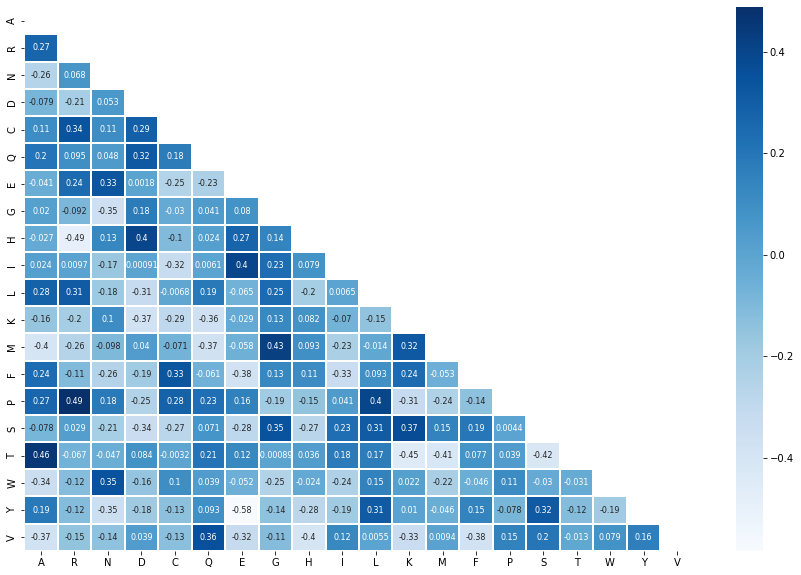

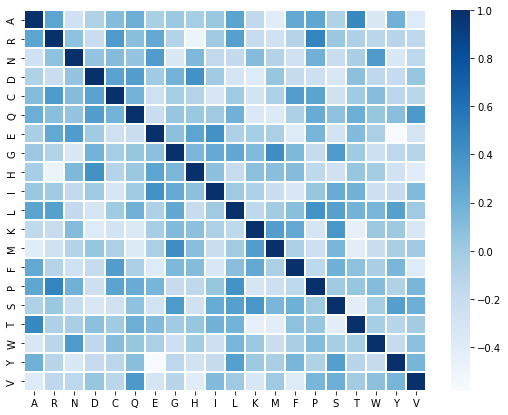

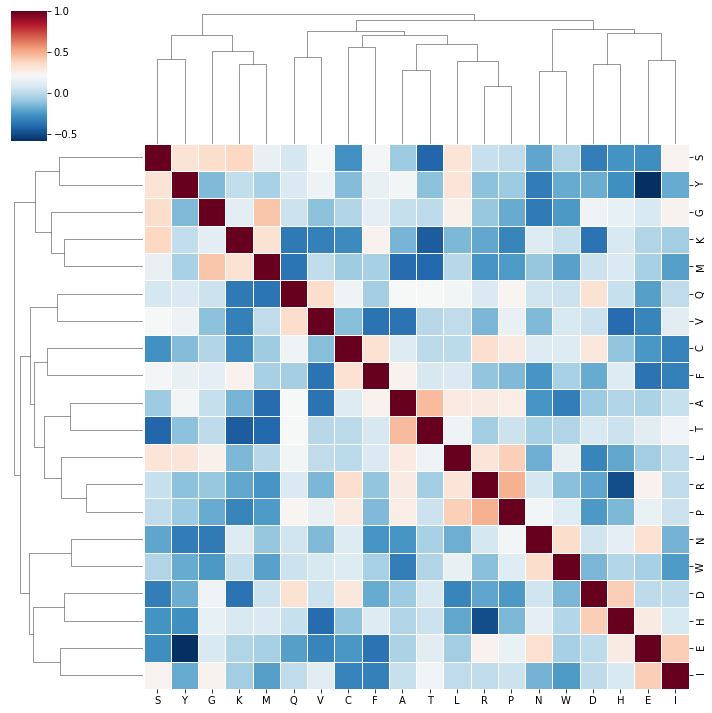

In [41]:
tbl_random = corrcoef_aas(embedding_dict_random, norm=None, pearson=False)

pearson_tbl_R = corrcoef_heatmap(tbl_random, columns, annot_= True, mask_=True)
pearson_tbl_R = corrcoef_heatmap(tbl_random, columns, sizex=9, sizey=7, annot_= False, mask_= False)
g = sn.clustermap(pearson_tbl_R, cmap='RdBu_r', linewidths=0.5, xticklabels=True, yticklabels=True)

## HEATMAP - LEARNED EMBEDDINGS (df:100%, dim:20)

In [42]:
embedding_dict_100p = {
'A': [-1.6956777572631836, 0.2410620152950287, -1.0528922080993652, -1.0916821956634521, 1.5685704946517944, -0.10447169095277786, 0.09802776575088501, 1.4021353721618652, 0.8441759943962097, 0.02580111287534237, 0.006774808745831251, -0.2569028437137604, -0.4446617364883423, -0.35448142886161804, 1.0847166776657104, -0.8138693571090698, -1.010623812675476, 2.461449146270752, 0.660132646560669, -1.4966636896133423],
'R': [-0.9469580054283142, 0.28312352299690247, 0.34649980068206787, 3.3505306243896484, -1.6836403608322144, -0.7191871404647827, -2.2491238117218018, -2.4936916828155518, 1.4078348875045776, 0.30280059576034546, 1.1407041549682617, -1.374695897102356, -2.8184361457824707, 1.650807499885559, 0.5346478819847107, 0.043256308883428574, 0.5504666566848755, -0.9169543981552124, 1.4529350996017456, -2.032514810562134],
'N': [1.8400269746780396, -1.5193018913269043, -1.979587197303772, -0.3117556869983673, -1.4724253416061401, 0.6648997068405151, -0.6011846661567688, 0.5034862160682678, 0.5626329779624939, -0.4496687352657318, -0.18585087358951569, 0.5520175099372864, 0.26442238688468933, -0.4139286279678345, -0.727891743183136, 2.828559398651123, -0.2585742175579071, -0.41330888867378235, 1.2263109683990479, -0.3030117154121399],
'D': [0.6131447553634644, -4.336853981018066, -2.0292623043060303, 0.7310842871665955, 0.7411388158798218, 1.591675877571106, -0.6807140707969666, -1.2344961166381836, 1.7167532444000244, 0.7326116561889648, -1.581544280052185, -1.3014156818389893, -0.22098210453987122, -1.2658621072769165, -1.665614366531372, -0.6343702673912048, -0.3964228332042694, 1.3171546459197998, -1.9138360023498535, 1.3860763311386108],
'C': [2.1749844551086426, -0.4085612893104553, -0.4972586929798126, 2.7311618328094482, -0.07801546156406403, 1.455184817314148, 2.713787317276001, 3.4982542991638184, 1.0022491216659546, 3.8518447875976562, 3.368122100830078, 2.2508318424224854, -1.7570439577102661, 0.25921499729156494, 0.9248730540275574, -0.06740061938762665, 0.9585371613502502, 0.48726531863212585, -1.5629725456237793, 2.0957884788513184],
'Q': [-1.0886441469192505, -1.1094013452529907, 0.20555832982063293, -0.6861791610717773, 1.010061264038086, 0.10105518996715546, -0.9085682034492493, -0.7368072867393494, 1.2714849710464478, -0.947542130947113, 1.886492133140564, -1.0626788139343262, 0.6792200207710266, 0.6538475751876831, 0.19525806605815887, 2.753169059753418, -0.5229524970054626, -1.8286300897598267, -0.21940506994724274, 0.4689364433288574],
'E': [-1.5410220623016357, 0.20208795368671417, -0.20262180268764496, 0.004199092276394367, -1.1621086597442627, 1.9705647230148315, 1.0060590505599976, -1.6178761720657349, 1.5744308233261108, 1.1304806470870972, -0.9681777358055115, -2.344086170196533, 0.37288302183151245, 0.5451346635818481, -1.4437419176101685, 1.0520663261413574, -1.2090240716934204, -0.25488099455833435, -1.2901184558868408, 1.4030745029449463],
'G': [-0.8610813021659851, -1.3660317659378052, 0.7043448090553284, -0.8442611694335938, -0.5460891127586365, 0.6449899077415466, -0.26310065388679504, -2.2510995864868164, 0.4011875092983246, -0.5578578114509583, 1.373810052871704, 2.1268134117126465, -1.3461681604385376, -1.7302030324935913, -0.873513400554657, 0.028721779584884644, -1.4276946783065796, 1.8653274774551392, 0.7606180310249329, 1.544013500213623],
'H': [-2.062385082244873, -0.5945270657539368, -2.5200047492980957, 2.0631871223449707, -0.298662394285202, -1.1551547050476074, -0.8557366728782654, -0.9053579568862915, 0.057367872446775436, 0.09615915268659592, 0.5577449798583984, 1.6102784872055054, 1.1641321182250977, 1.2227189540863037, -1.1567718982696533, -1.2024883031845093, 0.6988549828529358, -2.997269630432129, 1.9201749563217163, -0.22112919390201569], 
'I': [0.6033464670181274, -0.1414763331413269, 1.765569806098938, -2.1063404083251953, 0.6110585331916809, -0.6916350722312927, -0.9167152047157288, 2.241238594055176, -0.25094982981681824, -0.577301561832428, -0.24476701021194458, 0.2087685614824295, 0.20456303656101227, -0.08302974700927734, -0.8021098971366882, -1.4927423000335693, 0.7741484045982361, -0.03264723718166351, -0.9542725682258606, -2.8559765815734863],
'L': [1.422662377357483, 0.23212409019470215, 0.6134034991264343, -2.6664767265319824, -0.5471692085266113, -1.0482832193374634, 0.8940984606742859, -0.09515140950679779, 0.2951562702655792, -1.5766055583953857, 1.0824259519577026, -1.7375319004058838, 0.6375750303268433, 2.200730562210083, 0.15236850082874298, -3.105990409851074, 0.7692270874977112, 0.5333343744277954, -0.6301074624061584, -0.9838540554046631],
'K': [-1.2783812284469604, -0.31237441301345825, -0.6943578124046326, -1.4770292043685913, -2.2983787059783936, -1.063806414604187, -1.5763310194015503, -1.0114972591400146, 0.6891336441040039, 1.2961454391479492, 0.6345139741897583, -2.3393850326538086, -2.2710204124450684, -2.543409824371338, -0.5764923095703125, -0.246614471077919, 2.6556389331817627, -0.3340241014957428, 2.103315591812134, -0.43815338611602783],
'M': [0.7740883231163025, -0.1241055354475975, -1.0625343322753906, -1.2933528423309326, 0.7034444808959961, 1.6339824199676514, 0.8867321014404297, -0.6122586727142334, -1.7255215644836426, -0.12531885504722595, 0.684952437877655, -1.4185436964035034, 0.49379807710647583, 0.8830453753471375, 1.9855839014053345, -2.108685255050659, 0.7069892883300781, -1.8340729475021362, -0.5469769239425659, -1.956560730934143],
'F': [0.6411863565444946, 0.547746479511261, 1.0217487812042236, -0.938295841217041, -0.513215184211731, 2.1363799571990967, -1.1570881605148315, 0.20988190174102783, -3.0397698879241943, -0.9563161134719849, -1.8323367834091187, 0.13742366433143616, 0.8251721858978271, 2.651019811630249, 0.27416151762008667, -1.2137800455093384, 1.6373180150985718, 1.6510581970214844, 1.1373553276062012, -0.39210668206214905],
'P': [-1.191692590713501, -1.3643229007720947, -1.5896269083023071, -1.698170781135559, 1.2950266599655151, -0.9754930138587952, 3.0280933380126953, -0.4199882745742798, 1.2752262353897095, -2.075348138809204, -1.7125974893569946, 0.8991172909736633, -3.831873655319214, 1.5164636373519897, -1.2667129039764404, 1.7306318283081055, -0.05341777205467224, -0.8122614026069641, -0.09284625202417374, 0.01573116146028042],
'S': [0.58223956823349, 0.9294551014900208, -0.8422594666481018, -0.013056446798145771, 0.4986971914768219, 1.9501926898956299, -0.46000951528549194, 0.9730392098426819, 1.6495598554611206, -1.2994911670684814, 0.0854191854596138, -0.41303750872612, -0.4934671223163605, -2.2776031494140625, -0.08330594003200531, -0.8974605798721313, -1.2118043899536133, -0.47383517026901245, 1.5105259418487549, 0.17913521826267242],
'T': [-0.05478149279952049, 0.36306509375572205, -1.0974891185760498, 0.806626558303833, -0.1645900309085846, -0.7007084488868713, -0.22496140003204346, 2.485217571258545, -0.40883758664131165, -2.4712014198303223, 0.3403148651123047, -1.4143160581588745, -0.4654528498649597, -1.7192641496658325, -0.16815295815467834, -0.626207172870636, -0.8996634483337402, 0.9207157492637634, -0.4348416328430176, 0.21397966146469116],
'W': [0.6583263278007507, -2.0021369457244873, 2.75199818611145, 1.4994815587997437, -1.1939799785614014, 0.6933709383010864, 2.997776746749878, -1.3321799039840698, 0.30320850014686584, 1.3448549509048462, -1.169924020767212, 1.8838512897491455, 2.5807483196258545, 0.6796616315841675, 1.689404010772705, 0.22555862367153168, 2.833861827850342, 1.9088834524154663, 2.320274591445923, -0.35293716192245483],
'Y': [1.548455834388733, 0.7258235812187195, 0.46446096897125244, -0.6650819778442383, 0.9160401821136475, -2.03843092918396, -1.7508699893951416, -1.7973164319992065, -1.9323596954345703, 0.3413209617137909, -2.666982650756836, -0.8564072251319885, 0.32328999042510986, 0.7531993985176086, 2.4212915897369385, -0.686341404914856, 1.616796851158142, -0.43315252661705017, 1.3013149499893188, 1.0726935863494873],
'V': [0.6235162019729614, 0.4364323318004608, 0.9372037053108215, -0.8779642581939697, 1.0400822162628174, -1.8675878047943115, 1.3113962411880493, 0.9717271327972412, -1.8037124872207642, 0.1012314110994339, 0.71847003698349, -1.4466813802719116, -0.09689098596572876, -0.41406285762786865, -0.9915820360183716, -0.2557655870914459, -0.705150306224823, 0.847257673740387, 0.4469163715839386, -2.288346529006958]
}

A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y, V, 

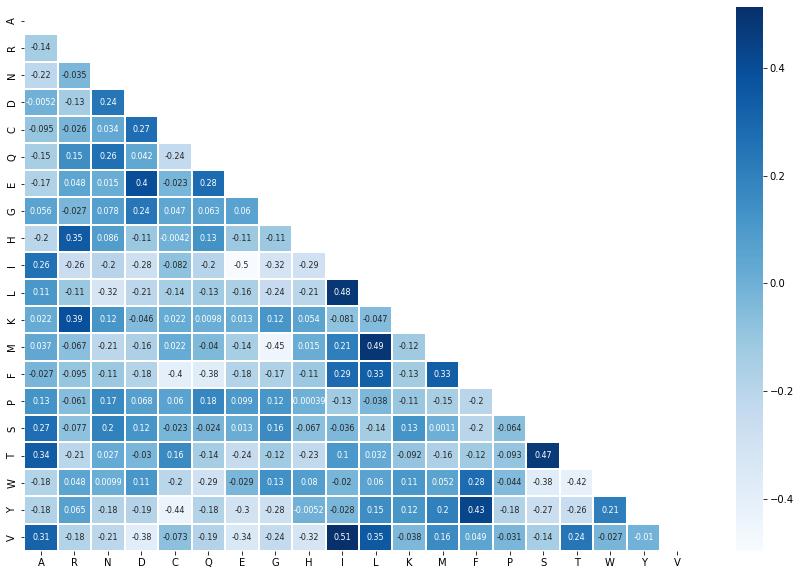

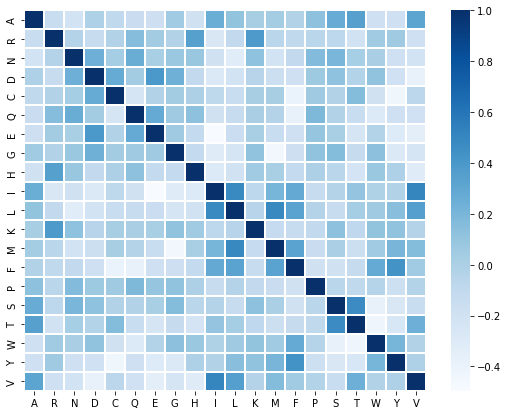

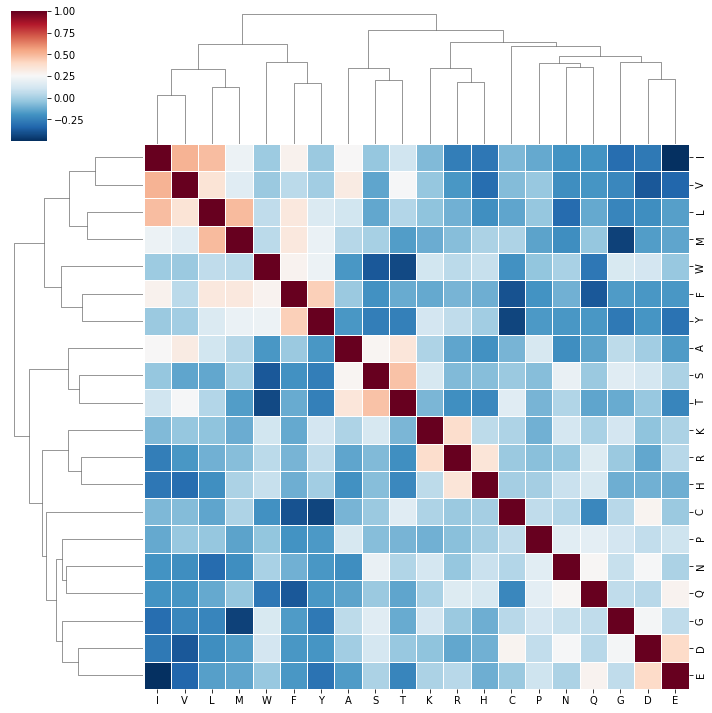

In [43]:
tbl = corrcoef_aas(embedding_dict_100p, norm=None, pearson=True)

pearson_tbl_L_100p = corrcoef_heatmap(tbl, columns, annot_= True, mask_=True)
pearson_tbl_L_100p  = corrcoef_heatmap(tbl, columns, sizex=9, sizey=7, annot_= False, mask_= False)

sn.clustermap(pearson_tbl_L_100p, cmap='RdBu_r', linewidths=0.5)


## HEATMAP LEARNED EMBEDDINGS - EMBEDDING-E & ED

In [46]:
embedding_dict_E_learned = {
'A': [-1.7566229104995728, -0.09708599746227264, -0.6203809976577759, -0.6863685250282288, 1.5155534744262695, 0.3527240455150604, 0.11604674905538559, 1.577946662902832, 0.08026495575904846, -0.1526356041431427, -0.2579202950000763, -0.2637425661087036, -0.6587985157966614, 0.005057297181338072, 1.2468390464782715, -1.2912241220474243, -0.9543593525886536, 2.3029251098632812, 1.3235557079315186, -1.7963645458221436],
'R': [-0.3978874981403351, 0.9861621260643005, 0.07511880248785019, 2.5863749980926514, -0.8094496130943298, -0.9668612480163574, -1.631896734237671, -2.2994868755340576, 1.193843126296997, -0.626990795135498, 0.7074797749519348, -1.3665777444839478, -2.001569986343384, 0.8666728138923645, 0.4092676341533661, -0.2989386022090912, 0.052433524280786514, 0.04438326880335808, 0.22276493906974792, -1.8977843523025513],
'N': [1.757684588432312, -1.0689510107040405, -1.4676769971847534, 0.2234848439693451, -1.6126333475112915, -0.386205792427063, -0.32917463779449463, -0.06001687049865723, -0.1562877595424652, -0.8129569292068481, 0.003214644966647029, 0.8997909426689148, 0.16170142590999603, -0.14425669610500336, -0.2802927494049072, 1.6531424522399902, 0.30123525857925415, -0.6091245412826538, 2.1751811504364014, -0.4677746891975403],
'D': [0.12333215773105621, -2.6330461502075195, -1.7549307346343994, 1.0375038385391235, 0.8862079977989197, 0.07431450486183167, -1.0640672445297241, -0.2762223482131958, 0.8724626898765564, 0.2783791720867157, -1.2150822877883911, -1.4918715953826904, 0.13095414638519287, -1.8308600187301636, -0.4239007532596588, -0.6998971700668335, -0.0605199933052063, 0.19298121333122253, -1.1989601850509644, 0.543891429901123],
'C': [0.8983960151672363, 0.8358246088027954, -0.6689563393592834, 2.274890661239624, -1.833074927330017, -0.368391752243042, -0.06137968227267265, 3.0223588943481445, 0.04379476606845856, 1.49982488155365, 1.9736963510513306, 1.868847370147705, -1.3238763809204102, -1.445600986480713, 1.2403815984725952, -0.3677438795566559, 0.9174339771270752, -0.46841514110565186, 0.61402428150177, 1.008750081062317],
'Q': [-1.377524733543396, -1.6205981969833374, 0.4495825469493866, -0.9499512314796448, 0.5434499382972717, 0.026310976594686508, -1.5554567575454712, -0.4538300633430481, 0.37600719928741455, -0.6153589487075806, 1.040242075920105, -0.48881784081459045, 1.0307066440582275, -0.2023800015449524, 0.3995678424835205, 2.576996326446533, -0.426693856716156, -1.2276843786239624, 0.30135563015937805, 0.025416672229766846],
'E': [-1.5620983839035034, 1.6244862079620361, 1.2206296920776367, -0.6960539817810059, -1.0524061918258667, 1.3006750345230103, 0.7682155966758728, -1.9691576957702637, 0.9953839182853699, 0.019111379981040955, -1.3127186298370361, -1.9993568658828735, 0.37436947226524353, 0.8911418914794922, -0.6345424652099609, 0.03727642074227333, -0.5142004489898682, -0.7894400358200073, -1.0716861486434937, 0.8535169363021851],
'G': [-0.5954411029815674, -0.42265814542770386, 1.007486343383789, -0.7556787133216858, 0.12823829054832458, -0.4334322512149811, 0.26607054471969604, -2.388564348220825, -0.49036407470703125, -1.4062221050262451, 0.6423560976982117, 2.112495183944702, -0.18851163983345032, -0.7729938626289368, -0.00649739895015955, -0.20003677904605865, -1.830330729484558, 1.152783751487732, 0.4995417892932892, 1.0680768489837646],
'H': [-1.7549470663070679, -0.2358243763446808, -1.5613528490066528, 1.1016753911972046, 0.6547866463661194, -0.8734866976737976, -0.1586690992116928, -0.5631436705589294, 0.835056722164154, -0.3481021225452423, 0.9991079568862915, 0.6731703877449036, 1.0224840641021729, 1.0346882343292236, -1.6193751096725464, -1.03513503074646, 0.4643787145614624, -2.404360294342041, 0.6489626169204712, -0.8719282746315002],
'I': [0.41613635420799255, -0.05379195511341095, 1.5078803300857544, -1.6823993921279907, -0.0795583575963974, -0.6574468612670898, -0.9542495608329773, 1.765005350112915, 0.029933735728263855, 0.5387228727340698, -0.16349755227565765, 0.5295814871788025, -0.06816669553518295, 0.5540491342544556, -0.7536885738372803, -1.6370946168899536, 0.8809009790420532, 0.8711872696876526, -1.616871953010559, -2.3761589527130127],
'L': [1.3460297584533691, -0.31369534134864807, 0.10689233243465424, -1.870205044746399, -0.7749879360198975, -0.3240014612674713, 0.5187393426895142, -0.4260527193546295, 0.5758621692657471, -2.2522051334381104, 1.1653950214385986, -1.248361349105835, 0.8400090336799622, 2.25934100151062, 0.11087161302566528, -3.0823678970336914, 0.780796468257904, -0.27598926424980164, -0.13987688720226288, -0.849726676940918],
'K': [-1.2061923742294312, -0.43112605810165405, -0.5402094125747681, -1.8810195922851562, -1.3932297229766846, -0.9495815634727478, -1.0415064096450806, -0.8134986162185669, 0.9715317487716675, 0.44010958075523376, 0.3952399790287018, -2.313493490219116, -1.5764399766921997, -2.2406013011932373, -0.6153972744941711, -0.037427861243486404, 2.2356364727020264, 0.010200022719800472, 0.8618788123130798, -0.6357133388519287],
'M': [-0.18854643404483795, 0.2803667485713959, -1.441695213317871, -0.04411840811371803, -0.3730558753013611, 0.7297829985618591, 1.2058571577072144, -1.4949084520339966, -1.3559234142303467, 0.09942398220300674, 1.543647050857544, -1.6568642854690552, -0.09313014149665833, -0.13911773264408112, 1.5397112369537354, -1.3049618005752563, 0.10508356988430023, -1.1562464237213135, -0.6530597805976868, -1.2065544128417969],
'F': [0.30123886466026306, -0.09722103923559189, 0.22427943348884583, -0.18740205466747284, -0.32529011368751526, 3.186038017272949, -1.6310805082321167, 0.2199511080980301, -2.8196535110473633, -0.9245116710662842, -1.6402515172958374, 0.7168921232223511, 0.4761045277118683, 2.518442392349243, -1.691246747970581, -0.587758481502533, 1.1338354349136353, 1.4819049835205078, 0.5631089806556702, -0.4477599263191223],
'P': [-0.05019714683294296, -0.848259687423706, -0.7847023010253906, -1.6759893894195557, 1.1351362466812134, -0.749410092830658, 2.467884063720703, -0.4564553201198578, 1.0633195638656616, -2.137828826904297, -1.895229458808899, -0.7052583694458008, -3.824439764022827, 1.0254697799682617, -0.888434648513794, 1.11014986038208, -0.3536420166492462, -0.6862314343452454, -0.19663019478321075, -0.030053041875362396],
'S': [0.8469670414924622, 1.531482219696045, -0.8422206044197083, -0.5169094204902649, -0.3425425887107849, 2.0312302112579346, -0.7152993083000183, 0.7758397459983826, 1.842964768409729, -1.183165431022644, -0.4473753571510315, -1.010613203048706, 0.06828431785106659, -1.5852882862091064, 0.27194899320602417, -1.3350138664245605, -1.2288382053375244, -1.4010865688323975, 1.9369463920593262, 0.6534929275512695] ,   
'T': [-0.1931031346321106, 0.47762954235076904, -0.676476776599884, -0.0026262213941663504, -0.464913010597229, -1.2806823253631592, 0.040623776614665985, 1.7042299509048462, -0.4796319901943207, -1.8447951078414917, -0.10489621758460999, -1.7646937370300293, -0.8421168327331543, -0.5682076811790466, -0.1290423572063446, -1.1691434383392334, -0.09592770785093307, 1.1389446258544922, -1.5817290544509888, -0.349727064371109],
'W': [0.27357444167137146, -1.5628446340560913, 0.5847493410110474, 0.6126850843429565, -1.1894720792770386, -0.8602474927902222, 2.0606579780578613, -2.316328525543213, 1.3681942224502563, 1.8908072710037231, -0.7041938304901123, -0.14978164434432983, 1.9566686153411865, -1.2517294883728027, 0.8200152516365051, -0.24655139446258545, 1.074782133102417, 0.27805882692337036, 1.6153004169464111, -0.16729816794395447],
'Y': [0.7298842668533325, 0.15102873742580414, 0.3093104660511017, -0.39967241883277893, 0.6925345659255981, -1.9273133277893066, -1.339714527130127, -1.2055537700653076, -1.2909215688705444, -0.5967345833778381, -2.584368944168091, -0.6045746803283691, 0.12352786213159561, 0.17510093748569489, 1.6005339622497559, -0.6983520984649658, 1.1358675956726074, -1.239806890487671, 0.46466419100761414, 1.1213743686676025],
'V': [0.13776855170726776, 0.3222140967845917, 0.2497604936361313, -0.2525187134742737, 0.24356187880039215, -0.9645107984542847, 1.3998500108718872, 0.028860682621598244, -2.2274463176727295, 0.6732365489006042, 0.3136500120162964, -1.246581792831421, -0.23142975568771362, -1.2534568309783936, -1.1897780895233154, 0.8777778148651123, -0.8008814454078674, 0.3369193971157074, 0.6928858757019043, -2.498900890350342]
}


embedding_dict_100p_ED_learned_64 = {
   
'A': [1.038696050643921, 0.47103527188301086, -0.01583811454474926, 0.251079261302948, 0.6712280511856079, 1.4123941659927368, -0.690212607383728, 0.43703290820121765, -0.5279057621955872, 2.2737975120544434, -1.0030765533447266, 0.2776568830013275, 2.7348291873931885, -0.14805009961128235, -0.4033193588256836, -0.7253325581550598, 0.21989735960960388, -1.2491403818130493, 0.06658575683832169, -1.400944709777832, -1.0587214231491089, -0.7435423731803894, 1.6536531448364258, 0.12729772925376892, -0.1989060640335083, -2.9512574672698975, -1.5395032167434692, -0.16089503467082977, 0.43843233585357666, -0.03196336701512337, -1.7080971002578735, 0.29493361711502075, 0.8727253675460815, 0.15367664396762848, -1.2256577014923096, -0.9245429039001465, -0.7146256566047668, -1.4855579137802124, -0.3692195415496826, -0.3225362300872803, -0.32399240136146545, 1.306977391242981, -0.6561891436576843, 0.450020432472229, -0.5643154382705688, -0.5015349388122559, 1.5319374799728394, -1.0814988613128662, 0.42950183153152466, -0.4245130717754364, 0.6962335705757141, -1.5583419799804688, -0.2789612412452698, -0.4924001693725586, 0.554547905921936, 0.8475539684295654, 0.4719294309616089, -0.04362459108233452, -0.3335186839103699, 0.23426981270313263, -1.0193098783493042, 1.2152841091156006, -0.3657364547252655, 0.2994822859764099],
'R': [-0.20311297476291656, 0.613813579082489, -1.540212631225586, -0.17923180758953094, 1.7370617389678955, 0.8576943874359131, 1.1346319913864136, 0.1583852916955948, 0.3313969373703003, -1.7745146751403809, 0.39266008138656616, 0.015838302671909332, -0.980199933052063, -2.330613613128662, -1.0582224130630493, -1.2458566427230835, 1.1140937805175781, -2.422372817993164, -1.3515971899032593, 1.4408420324325562, 2.7077434062957764, 1.3336999416351318, 0.9129356741905212, 1.6628351211547852, 2.7077696323394775, -0.2737658619880676, 0.4393377900123596, -2.9956061840057373, 0.7742668390274048, 2.794989824295044, -0.8070363402366638, -0.2518273591995239, 1.9422191381454468, -1.1798020601272583, 0.09752298891544342, 0.1609281599521637, -0.8703727722167969, 0.18382640182971954, -0.1792783886194229, -2.268514394760132, 0.5595815777778625, -0.25044527649879456, -0.024063024669885635, -0.6405867338180542, -0.2557055950164795, -0.06989745795726776, -0.13460472226142883, 0.16834290325641632, 1.0121057033538818, -0.24622271955013275, -0.4873233437538147, -1.6689529418945312, -0.13929228484630585, 0.6320963501930237, 2.4832823276519775, 0.2892695367336273, -1.8956799507141113, -0.06498007476329803, 0.7507258653640747, -0.43330541253089905, 0.22769971191883087, -0.7397403717041016, 3.168349027633667, 2.288081645965576],
'N': [-0.08092324435710907, 0.5931169390678406, -0.010706407018005848, -0.2376691699028015, -0.7259805798530579, -2.0699989795684814, -1.0857923030853271, 0.05635567754507065, -0.7768589854240417, -2.109541654586792, -2.2879638671875, 0.8573224544525146, 1.5280237197875977, -0.6205950975418091, 1.116426944732666, 0.6189859509468079, -1.1961385011672974, 0.45541897416114807, 1.6762079000473022, -0.6617001891136169, -2.0197596549987793, 1.812915325164795, -1.4068944454193115, 1.3331537246704102, 1.6686033010482788, -1.4620085954666138, 0.027937734499573708, -1.2852462530136108, -1.1494364738464355, -0.12922585010528564, -0.9600381851196289, 1.5825673341751099, -0.1942795366048813, 1.2258691787719727, -0.7623181343078613, 0.476624995470047, 0.06378760933876038, 0.10972485691308975, 0.6086889505386353, 0.3694974482059479, 0.9358047246932983, -0.7653684616088867, 1.5849840641021729, 0.10218270123004913, 0.7776362895965576, -1.7532142400741577, -1.7069566249847412, -0.2773599326610565, -1.4808201789855957, 0.44602009654045105, 0.3184915781021118, -0.8381045460700989, -0.06622771173715591, -0.7688612937927246, -0.6718873977661133, -1.836530327796936, 0.10537928342819214, -0.11999133974313736, 0.26446738839149475, -0.11528240144252777, -2.091826915740967, -1.1626893281936646, 2.1753220558166504, 1.4694122076034546],
'D': [0.4225073456764221, -2.29338002204895, 0.3196794092655182, -1.414585828781128, -1.1061017513275146, -1.7229217290878296, -0.8998668789863586, 0.750870406627655, -0.7793624401092529, -2.494152069091797, -0.23610296845436096, -0.2970075309276581, 0.7074291706085205, -0.43138107657432556, -0.8920486569404602, 0.25880786776542664, -2.351405382156372, 0.5626214146614075, -2.0486927032470703, 0.30204063653945923, -0.35136955976486206, -0.18745321035385132, 0.06842614710330963, 1.5600868463516235, 0.05797135829925537, -0.3547345697879791, -0.406974196434021, -1.708174467086792, -2.871617317199707, 0.6701295375823975, -1.3874987363815308, -0.4402799606323242, -0.8439116477966309, 2.0454232692718506, -2.698735237121582, -1.3927685022354126, -0.13871294260025024, 0.5384738445281982, 0.32892292737960815, 0.7107754945755005, -2.1541435718536377, 0.5633658170700073, 1.7863043546676636, 0.6203610897064209, 0.6276184320449829, -2.5079970359802246, -0.6923826336860657, 0.5530375242233276, -1.6843935251235962, 2.011718988418579, -3.534597396850586, 0.16977810859680176, -2.129690647125244, -1.5332597494125366, -1.110600471496582, 0.8099738955497742, -0.45513319969177246, -2.4252543449401855, 0.8377913236618042, -1.098942756652832, 1.7692128419876099, 0.2244444489479065, -1.3904027938842773, 0.14807955920696259],
'C': [1.3207306861877441, -1.6653156280517578, 3.7616288661956787, 0.04813811182975769, -2.817153215408325, 1.2107069492340088, 0.6125329732894897, -0.6159941554069519, -1.699834942817688, -0.8207263946533203, -0.9019461274147034, 3.043879508972168, -0.5060839653015137, 1.3775739669799805, 2.380976438522339, -3.635441303253174, -2.204793930053711, 0.08948805183172226, -0.6980389952659607, -1.5559779405593872, 2.381183624267578, 0.8488206267356873, 0.023471806198358536, 3.2738137245178223, 1.5779187679290771, -0.028338519856333733, 0.8053200244903564, 2.1257340908050537, -1.3882925510406494, 1.3027307987213135, 2.2218637466430664, -0.01256608683615923, -1.4552820920944214, 3.9500184059143066, 0.46522635221481323, -2.3484325408935547, -3.0088350772857666, -0.12191514670848846, -2.3245387077331543, 1.6436209678649902, 1.7150213718414307, -0.22769200801849365, 0.44583502411842346, 0.23302501440048218, 2.0234012603759766, -0.6061339378356934, 2.039471387863159, 2.7216434478759766, 2.6443891525268555, 1.396889090538025, -0.24185563623905182, -1.1225061416625977, -0.840709924697876, -2.79118275642395, 1.6660257577896118, -0.3589756190776825, 1.4637914896011353, 0.07618404924869537, -0.837391197681427, -1.3590809106826782, -0.7326635718345642, -1.879514455795288, -0.5481207966804504, 2.6811304092407227],
'Q': [-1.4808812141418457, -0.44921672344207764, -0.3929775357246399, -0.054499633610248566, 0.7462223768234253, -0.8830719590187073, 1.8033616542816162, 1.0114998817443848, 1.0037657022476196, -0.9531541466712952, 2.0960466861724854, 0.9498965740203857, -0.4718635678291321, 0.9496141076087952, 0.687259316444397, 0.03939209505915642, 0.40160995721817017, 0.5657398104667664, 1.8756910562515259, 0.9979915618896484, 0.5486464500427246, -0.2566683888435364, 0.32308971881866455, -0.5834670662879944, 0.23799747228622437, -0.903483510017395, 0.8438695669174194, -1.245239019393921, -0.7466707825660706, 0.9583002328872681, -1.4847986698150635, -0.14455297589302063, -0.36932703852653503, 1.7715370655059814, 0.15718434751033783, -0.956087052822113, -0.4918621778488159, 1.9257140159606934, 0.995551347732544, 0.8370726704597473, -1.229817271232605, 0.7326292991638184, -1.0761525630950928, 1.1123124361038208, 0.8185667395591736, -0.7020300030708313, 1.077860951423645, -1.1067253351211548, -0.37881970405578613, 1.7787303924560547, 1.7704153060913086, -0.42334580421447754, -1.0120359659194946, 0.9646408557891846, -1.2967637777328491, -0.18249614536762238, 0.31751418113708496, 0.7838008999824524, 1.418175220489502, 0.11180125176906586, -0.9858749508857727, -1.1647199392318726, -0.3715200126171112, 0.9956442713737488],
'E': [0.37423765659332275, -0.41427892446517944, -1.6868386268615723, -2.8496553897857666, 2.0165984630584717, -0.9294320940971375, 0.47410282492637634, -1.1105276346206665, -0.8728871941566467, -2.202293872833252, -1.4782192707061768, 1.088616967201233, 0.6408642530441284, 0.6753310561180115, -0.7240191698074341, -1.014817237854004, -0.3932783305644989, 1.2918610572814941, -0.32221606373786926, -2.46927809715271, -0.42457666993141174, -0.37586510181427, 0.5077118873596191, 0.49686524271965027, -1.0730578899383545, -1.035192608833313, 1.4171477556228638, -0.7825894951820374, -1.1917600631713867, -0.5073984861373901, -0.954159140586853, 0.9348750710487366, -0.17470115423202515, -0.44451218843460083, -1.918297290802002, -1.8583827018737793, 2.0427446365356445, 2.0907838344573975, 0.4349210262298584, -1.3249117136001587, -0.23690374195575714, -0.3243119418621063, 0.39847424626350403, 0.8308281302452087, 1.2618718147277832, 0.16253378987312317, 0.7936168313026428, 2.0685455799102783, 0.019069261848926544, 0.9665590524673462, 0.016604037955403328, 0.6847310662269592, -2.024203062057495, -0.48458588123321533, 0.6626507043838501, 1.1956346035003662, 0.7993780970573425, 0.5086176991462708, 1.892410397529602, 1.5011264085769653, 1.455820083618164, 1.3715097904205322, -0.03681018203496933, 0.8061099648475647],
'G': [1.926617980003357, -0.4272908866405487, 1.6688743829727173, 0.7026989459991455, 1.0363681316375732, -1.0279861688613892, -0.43363797664642334, -0.4470530152320862, -1.6324783563613892, 0.14320290088653564, 0.21136245131492615, 0.30662262439727783, 1.2631850242614746, -0.9659748673439026, 1.1800998449325562, 0.37861335277557373, -0.2781536877155304, 0.5368391275405884, 0.4440871477127075, -2.1504924297332764, 2.1078996658325195, -0.20663131773471832, 2.3768310546875, -1.3852282762527466, 0.3977246880531311, 1.2577544450759888, 2.0804266929626465, -1.8712158203125, -1.056684136390686, -0.5605224967002869, -0.5378574728965759, -0.09837024658918381, 1.2845864295959473, -1.5939440727233887, -0.04861259087920189, -1.1509217023849487, -0.5291168689727783, 0.049875229597091675, -0.8439900279045105, 0.80026775598526, -0.5374391078948975, 0.9324336647987366, -0.13001395761966705, 1.0776911973953247, -0.20991943776607513, -0.6252464056015015, -0.39449456334114075, 0.5432941317558289, -0.7472610473632812, 0.4919857978820801, -0.40140029788017273, 0.8108189702033997, -1.1473307609558105, 0.5314183831214905, -0.5418074727058411, -0.37807467579841614, 0.15282435715198517, 1.290570616722107, 0.9859880805015564, -2.3488779067993164, -1.1135051250457764, -1.8462190628051758, -0.7425210475921631, -2.357651710510254],
'H': [-1.0317057371139526, -0.952219545841217, 0.026629751548171043, -1.0139871835708618, 1.788644552230835, 0.24257417023181915, -1.3565343618392944, -0.6822060942649841, 0.8328447937965393, 0.16740785539150238, 1.870803713798523, 1.1213655471801758, 0.9884568452835083, 0.05780097097158432, 0.1612519919872284, 2.0332727432250977, -0.11958842724561691, -0.4908638000488281, 1.5586800575256348, 0.6506399512290955, 0.32765668630599976, 1.3826186656951904, 0.935318648815155, 3.4520065784454346, -0.3381998836994171, 0.6218833327293396, -1.4720618724822998, -2.4641919136047363, 0.7298552393913269, 0.32946017384529114, 0.9146794080734253, -1.520980954170227, -0.8129884004592896, 0.13846604526042938, 0.8281707763671875, 0.37352254986763, 0.6003760695457458, 0.34584468603134155, 0.3359835147857666, -2.7684147357940674, 1.9104483127593994, 0.5903191566467285, 0.033377792686223984, -0.8732708096504211, 1.3939838409423828, -1.9890497922897339, -0.9010306596755981, -0.26401907205581665, -1.0290216207504272, -1.3698177337646484, -2.8035707473754883, 0.6910609006881714, -0.6721475720405579, 0.73783278465271, 1.675926923751831, 0.15902526676654816, 0.4107828438282013, 0.2658723294734955, 0.2635651230812073, 1.1598904132843018, -0.39910420775413513, -0.08839519321918488, 1.7717808485031128, -0.47197967767715454],
'I': [0.8968678712844849, 0.5034582614898682, 0.2835972309112549, -0.766417384147644, -2.008593797683716, 1.0144046545028687, 1.6270155906677246, 1.051101803779602, -0.15114903450012207, -0.8870518803596497, -1.7826977968215942, -0.18633782863616943, -0.5897213816642761, -0.5088248252868652, 1.0785807371139526, 1.3733831644058228, -1.1650890111923218, -1.2899421453475952, -0.43194708228111267, -0.5855250358581543, 0.3258793354034424, -0.4801313281059265, -1.15840482711792, -1.2717397212982178, -0.9226542115211487, 0.2610190808773041, 0.3575226366519928, -0.24122753739356995, 1.3737173080444336, -1.464707374572754, -0.34659215807914734, -0.38096797466278076, 0.14127810299396515, 1.5485823154449463, 0.7778803706169128, 0.9248604774475098, -0.013187223114073277, -1.6272335052490234, 1.9734718799591064, 0.4307880997657776, -2.7874815464019775, 0.7502999901771545, -0.35324713587760925, -1.6962356567382812, -0.3133663237094879, -1.0922330617904663, 0.5087718963623047, -1.1943986415863037, 0.9098052978515625, 1.4520394802093506, 0.16303113102912903, -0.41398605704307556, 1.725426197052002, -0.26243939995765686, -0.7538890242576599, -1.3323734998703003, -0.7117071151733398, 0.02307109348475933, -2.339888572692871, 1.4573664665222168, -0.8431909084320068, 0.8039281368255615, 0.7126826643943787, -0.3450152277946472],
'L': [-0.7639961838722229, 0.5919255018234253, 1.5420321226119995, -1.3408316373825073, -0.8979666233062744, 0.1266712099313736, 0.20479393005371094, 1.296295404434204, -0.9474435448646545, 0.3734472990036011, -1.1157456636428833, -1.6043318510055542, -0.1792096197605133, 2.9650778770446777, -0.3258161246776581, 0.1259886920452118, 0.3400394916534424, -0.22007368505001068, -0.7285513877868652, 1.041805624961853, 0.47626709938049316, 0.9834251403808594, -2.1520917415618896, -2.356354236602783, -0.9571651816368103, 0.4389260709285736, 0.27681103348731995, 0.6635329723358154, 1.2851147651672363, -1.3951970338821411, 0.0373205691576004, 0.3582017123699188, -0.9805285930633545, 2.1221413612365723, -0.6251673102378845, -0.16338342428207397, -0.08383266627788544, -1.1745070219039917, 0.1284545212984085, -0.5874682068824768, -0.8020357489585876, -1.5635647773742676, -1.3625288009643555, -1.5489146709442139, -1.090927243232727, -0.5799627900123596, 0.17503345012664795, -0.7179208993911743, 1.0918352603912354, -0.5154025554656982, 0.905329704284668, -2.0146729946136475, -0.2878437936306, 0.43291378021240234, 3.0787339210510254, -1.9422595500946045, -0.1144649013876915, 0.8875267505645752, -0.09850392490625381, 0.47416776418685913, 0.5433815121650696, -0.6644913554191589, -0.5278373956680298, -0.7135469913482666],
'K': [-2.1345531940460205, 1.11142098903656, -2.048262119293213, 1.7850818634033203, 0.22407317161560059, 1.6114084720611572, -1.747700572013855, -0.7109487056732178, -0.2231157273054123, 0.5169211626052856, -1.3414866924285889, -0.2709968686103821, -0.7728472948074341, -1.9345366954803467, 0.2187270075082779, -2.4918105602264404, -2.726288318634033, -0.2760102450847626, -0.1376611739397049, 0.877973198890686, 0.20225748419761658, 0.7644665837287903, -1.192600131034851, 0.2829612195491791, 0.9396870136260986, 0.9853870868682861, 1.09535551071167, -2.451385259628296, 0.37232378125190735, 0.7124995589256287, 0.28234153985977173, -1.1135804653167725, 1.4211838245391846, -2.80471134185791, 0.05229193717241287, -0.2862662971019745, 0.5635332465171814, -0.4627084732055664, -1.3057492971420288, -1.6695021390914917, -0.14606210589408875, -0.3913712203502655, -0.6624881029129028, 0.6824203729629517, 0.4899645149707794, 1.1199442148208618, -1.4902493953704834, -1.219840168952942, -0.570242166519165, 0.8725404143333435, -2.249049425125122, -2.084120273590088, -0.2681148052215576, 1.1596391201019287, 0.38985562324523926, -1.86980140209198, 1.757593035697937, -1.1904449462890625, 0.7563050389289856, -1.1726962327957153, -0.12010488659143448, -2.3933815956115723, 1.804703950881958, 2.1516406536102295],
'M': [-0.700647234916687, 0.3523380160331726, 1.9385336637496948, 0.19141508638858795, -0.007901213131844997, -0.07576064020395279, 1.2689498662948608, 0.4431435167789459, 2.2968990802764893, 0.7480937838554382, -1.1820660829544067, 0.497293084859848, -0.49724486470222473, 2.2397162914276123, 0.04939718917012215, -1.7425916194915771, -0.3242780864238739, -1.296860694885254, -0.7708646059036255, 0.2554960250854492, 1.2969990968704224, -3.4927456378936768, -0.8226631879806519, -0.0274850782006979, -0.4428503215312958, -1.5738368034362793, -0.14386329054832458, 1.6056205034255981, 1.3866130113601685, -0.7559970021247864, 0.6639103889465332, -1.6442184448242188, 0.22135695815086365, 2.174821138381958, -1.1912111043930054, -1.065869688987732, 0.6673104763031006, 0.21236154437065125, 0.046965669840574265, -0.19382257759571075, -0.9376706480979919, -0.5388723611831665, 0.5832772254943848, -1.1435397863388062, -1.1520881652832031, 0.020994244143366814, -1.4040029048919678, -1.427553653717041, -0.029033556580543518, -2.7578177452087402, 1.513226866722107, -0.7821850180625916, -0.24295814335346222, -2.463697910308838, 0.9308586120605469, -0.9450251460075378, -2.0229053497314453, 1.1162422895431519, -0.8647294044494629, 2.3747246265411377, -0.9904335141181946, -0.3113122582435608, -0.641277015209198, 0.6555867791175842], 
'F': [-0.7862862348556519, -0.6595009565353394, -0.8371076583862305, -0.21015362441539764, -2.9076132774353027, 1.2426512241363525, 0.7800431847572327, -3.5737314224243164, -0.21916227042675018, 0.8532668352127075, -2.406137228012085, -1.3952223062515259, 0.06061553210020065, 1.733859658241272, -0.28030768036842346, 1.1746984720230103, 1.5072071552276611, 1.6026830673217773, -0.2985665500164032, 0.2687406837940216, -0.6605053544044495, -0.6003828048706055, -1.0884370803833008, -0.12947101891040802, -0.006569873075932264, 0.7881248593330383, -1.4654090404510498, -0.22372862696647644, 1.0457038879394531, -1.225101351737976, -0.29097625613212585, -0.6396977305412292, -2.6318016052246094, -0.9326092004776001, 1.8334660530090332, 0.919320285320282, 0.9667719602584839, -0.20813362300395966, -2.1887311935424805, -0.9247332811355591, -1.2549279928207397, -1.1109983921051025, -0.22691960632801056, -1.3491390943527222, -0.5601977109909058, -0.794582724571228, -1.349328875541687, -1.1157804727554321, -0.585446298122406, -0.5565546154975891, 1.1295735836029053, 0.18977805972099304, 0.055631883442401886, -1.8743133544921875, -0.02028501220047474, -0.48798224329948425, -1.6852043867111206, 0.3374125361442566, -2.084291934967041, -0.823307454586029, 1.0481904745101929, -1.1132665872573853, 1.2667145729064941, -0.5848475694656372],
'P': [-2.011256456375122, 0.8923013210296631, -0.32960042357444763, -0.46619561314582825, 1.4431301355361938, -1.0358511209487915, -2.061121702194214, 1.2627681493759155, -2.487790107727051, 2.1519763469696045, -0.2295028567314148, 1.2503958940505981, -0.3481537401676178, -0.4877777695655823, -1.3807621002197266, -2.3378896713256836, 0.6472474336624146, 0.19814719259738922, 0.6943190693855286, -0.9724289178848267, -0.6333486437797546, 0.2688544988632202, -0.06441182643175125, -2.189941167831421, -0.7803934216499329, -1.1420936584472656, 0.8707345128059387, -0.6534271240234375, -1.9336751699447632, 0.051290664821863174, -1.6811217069625854, -2.2146947383880615, -0.9137507081031799, 1.9398612976074219, 1.157240867614746, 0.4160394072532654, -1.3048173189163208, 2.238557815551758, 1.1066772937774658, 0.880646824836731, -0.44172853231430054, 1.7789785861968994, 2.585022449493408, -2.4190080165863037, 1.3671646118164062, -0.27031126618385315, 0.19302698969841003, 0.6724065542221069, 0.6761435270309448, -0.9340723752975464, -1.3262412548065186, 0.2817641496658325, -0.11253263801336288, 0.9668705463409424, 2.78346848487854, 3.341724157333374, 0.4017205238342285, -1.7450587749481201, -1.920042872428894, -2.085714340209961, -2.0620908737182617, 0.6310024261474609, -0.3558966815471649, -1.2316099405288696],
'S': [1.0614992380142212, 0.6675077676773071, -1.2464704513549805, 0.3841245770454407, -0.8950273394584656, -0.2921661138534546, 0.6615905165672302, -0.11442644894123077, 0.0980350524187088, -1.2921963930130005, 0.11547012627124786, 0.007744850590825081, 1.300273060798645, 1.290619969367981, 0.11907406896352768, 0.31595683097839355, 0.14906086027622223, -0.22525857388973236, -1.0301079750061035, 0.8390231132507324, -1.178489089012146, 1.832512378692627, 1.540318489074707, -0.4787309765815735, 1.101780891418457, -1.3957983255386353, -0.15010161697864532, -0.5957366228103638, -1.3280247449874878, -1.0156587362289429, -1.1182454824447632, 0.18406060338020325, -0.08295439183712006, 1.0144315958023071, 0.38037702441215515, -1.6499674320220947, -0.4924074411392212, 0.5526382923126221, 0.39141473174095154, 1.1570923328399658, 1.1380088329315186, 1.1776942014694214, -0.22920013964176178, 1.4187265634536743, -2.1775059700012207, 0.4998970627784729, 0.6048855781555176, 0.37822234630584717, -0.578368604183197, -1.2874836921691895, -1.4959417581558228, 0.6786425709724426, 0.629287838935852, 0.7656060457229614, -0.4211563169956207, -0.7084252834320068, 1.2137302160263062, -0.0719771608710289, -1.268917441368103, -0.4442298710346222, -0.6244972348213196, 0.5473096966743469, -0.5889463424682617, 1.622137188911438],
'T': [0.8159195184707642, 1.7470639944076538, -0.492432177066803, 0.8767964243888855, -2.5914828777313232, -0.38776570558547974, -0.9380818009376526, 0.4092990458011627, -0.40049582719802856, 1.6040167808532715, -0.848204493522644, 0.22299304604530334, 0.2635153532028198, 1.7158952951431274, 0.45548394322395325, 0.6454915404319763, 0.20464521646499634, 0.639967143535614, -1.2030776739120483, 0.23058271408081055, -1.3678499460220337, 0.06253619492053986, -0.08076810091733932, -0.03881349414587021, 1.074104905128479, -1.6126636266708374, 0.8841623067855835, 1.0431618690490723, -0.6028305888175964, -0.5166483521461487, -0.20313555002212524, 1.236812949180603, 0.39027395844459534, 0.08264611661434174, -0.8931757807731628, 0.24325354397296906, -0.13481473922729492, -0.008426746353507042, 1.332572340965271, -0.8545874357223511, 2.0058767795562744, 1.1620278358459473, -0.5379316210746765, -0.3007476031780243, -0.33746054768562317, 0.2339896857738495, 1.2728946208953857, -0.8330960869789124, 0.31695282459259033, 0.5070960521697998, 0.20878759026527405, 1.8184809684753418, 0.6330975294113159, 1.3113278150558472, 0.31834763288497925, 0.6829286217689514, -0.9973117113113403, 1.983292818069458, 0.059762004762887955, -0.1383705884218216, 0.04687527194619179, 1.7629289627075195, -0.1727587878704071, 1.4151681661605835],
'W': [-0.9197285175323486, -3.4257259368896484, -0.8884445428848267, -2.5372085571289062, -1.8530488014221191, 0.460078626871109, 0.07908759266138077, -2.257901906967163, 1.05132257938385, 1.2644500732421875, -2.7183871269226074, -0.446235716342926, -2.51839280128479, 1.3677778244018555, 1.919913411140442, -0.523148775100708, -0.9669950604438782, 2.9533236026763916, 1.9679028987884521, -2.159083843231201, 1.8781640529632568, -0.22391442954540253, -2.1118698120117188, -1.4402803182601929, 1.0726940631866455, 2.763535737991333, -1.4892336130142212, 0.07161791622638702, 0.22960227727890015, 1.1512666940689087, -0.3167543411254883, 0.46926558017730713, -1.2691634893417358, -1.234494924545288, 0.054571107029914856, -2.9244368076324463, -1.042254090309143, -0.2630089819431305, -1.9035849571228027, -0.1251779943704605, 1.5324022769927979, 1.5657209157943726, 0.7292272448539734, -2.892009735107422, -2.099565029144287, -2.467041015625, -1.556464672088623, 0.3070031404495239, 3.8766212463378906, 0.8300186991691589, 0.9957780838012695, -0.6256103515625, 2.310077667236328, -1.3037211894989014, -2.063234567642212, 1.052573561668396, -1.8126115798950195, -1.1244242191314697, 0.3126887381076813, 0.5717509388923645, 0.8024199604988098, -0.36842891573905945, 1.1235904693603516, 1.5012511014938354],  
'Y': [-0.8836720585823059, -0.6532179713249207, -1.3751505613327026, -0.7518280744552612, -0.5663111805915833, -0.8014675378799438, 1.2301465272903442, -1.2378604412078857, 0.34220078587532043, 2.649859666824341, -0.4812912046909332, 1.2540786266326904, -1.5987610816955566, 2.5249197483062744, -1.841607928276062, -1.1999000310897827, 0.09000188112258911, -1.1231441497802734, 1.729426383972168, 2.983396053314209, -1.3221474885940552, -0.314354807138443, -0.33803144097328186, 1.72745680809021, -1.0106394290924072, 1.9091155529022217, -2.720996618270874, 0.46821796894073486, 0.7812836170196533, -3.0464088916778564, -0.6344016790390015, -0.3975928723812103, 1.9794648885726929, -1.0048346519470215, 0.9673225283622742, -0.06862691044807434, 1.1713969707489014, -3.333704710006714, -1.8626819849014282, -0.294197678565979, -1.7273937463760376, -2.299237012863159, -0.3152088224887848, -0.3017525374889374, -1.3038818836212158, 0.41341036558151245, -2.5597949028015137, 0.0050214254297316074, 1.9183026552200317, -0.9289725422859192, 0.851259708404541, -0.751620352268219, 0.2865535318851471, -1.1737794876098633, -0.6829283833503723, 0.9910724759101868, -2.812467336654663, -0.7808792591094971, 0.4028469920158386, -1.0223556756973267, 2.379328489303589, -0.5833367109298706, 1.296523928642273, 0.11958008259534836],
'V': [0.7058882117271423, 0.44354361295700073, 0.4277776777744293, 1.1336455345153809, 0.5005515217781067, 0.520996630191803, 2.3893978595733643, 0.5103389620780945, -0.3921104371547699, 0.2457173615694046, -0.7632554173469543, -2.0828680992126465, 0.7415860891342163, -0.31256160140037537, 2.6348876953125, 0.3605317771434784, 0.6705170273780823, -1.595310926437378, -1.6537868976593018, -0.6393138766288757, -2.839367389678955, 0.401578813791275, -0.9699712991714478, 0.10679558664560318, -0.288435697555542, 0.05984945595264435, -0.13750049471855164, 0.607731282711029, 0.14495377242565155, -0.6564074754714966, 0.9707133173942566, -1.1690601110458374, 0.01655435375869274, 0.8371497988700867, -1.0507781505584717, 1.8729068040847778, 0.11129656434059143, -0.23947051167488098, -0.04104511812329292, 0.3094160854816437, -0.43738844990730286, 1.0417170524597168, -1.095046877861023, -1.1986994743347168, 1.0144202709197998, 0.5812519788742065, -0.46311384439468384, -1.3262771368026733, 1.3840283155441284, -0.14892692863941193, 0.3406580090522766, -2.330381155014038, -0.26297497749328613, -0.35083696246147156, 0.8144572973251343, -0.2729230523109436, 1.0689074993133545, -1.6609365940093994, 0.27809658646583557, -0.3366922438144684, 0.3652341365814209, 2.494264602661133, -0.37928077578544617, -2.560793399810791]
}



A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y, V, 

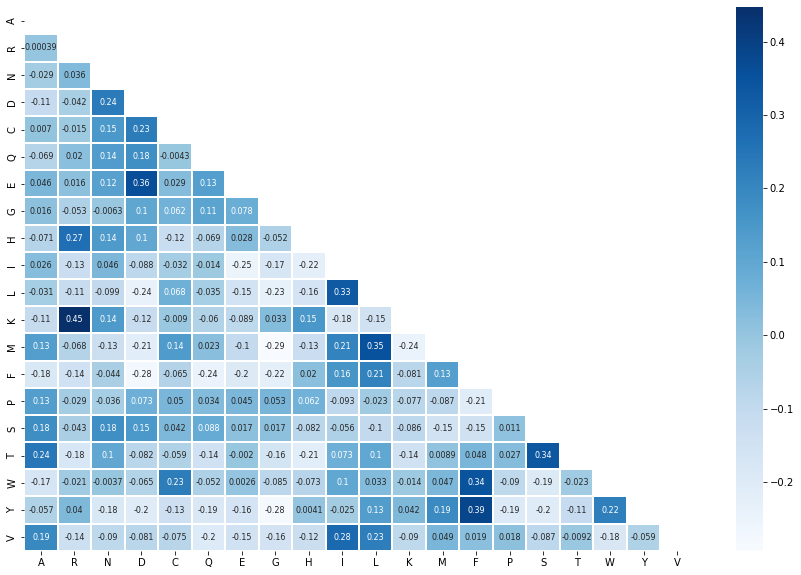

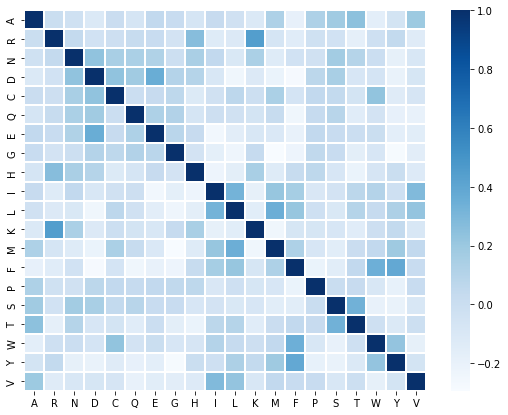

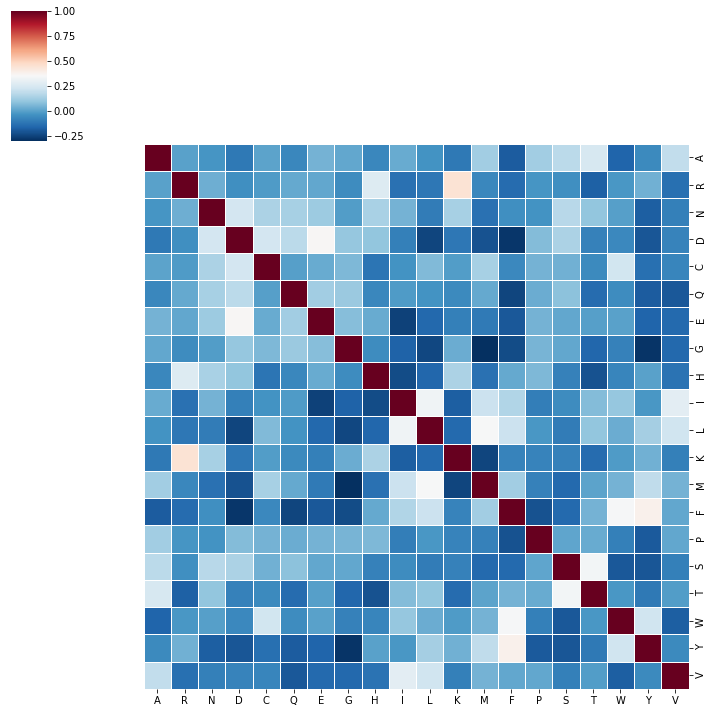

In [50]:
embedding_dict_100p_ED_learned_64

tbl = corrcoef_aas(embedding_dict_100p_ED_learned_64, norm=None, pearson=True)

pearson_tbl_ED64_L = corrcoef_heatmap(tbl, columns, annot_= True, mask_=True)
pearson_tbl_ED64_L  = corrcoef_heatmap(tbl, columns, sizex=9, sizey=7, annot_= False, mask_= False)
g = sn.clustermap(pearson_tbl_ED64_L, cmap='RdBu_r', linewidths=0.5, xticklabels=True, yticklabels=True, col_cluster=False, row_cluster=False)


In [26]:
pearson_tbl_ED64_L

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,1.000000,-0.006273,-0.015729,-0.067325,-0.004628,-0.084992,0.045033,0.021023,-0.079471,0.036719,-0.017497,-0.086541,0.141537,-0.143007,0.138707,0.176513,0.211705,-0.149904,-0.040668,0.194532
R,-0.006273,1.000000,0.025597,-0.064408,-0.005358,0.033033,0.016109,-0.056738,0.271338,-0.134748,-0.121978,0.418589,-0.076989,-0.158044,-0.035881,-0.041511,-0.151908,-0.031679,0.027130,-0.136288
N,-0.015729,0.025597,1.000000,0.268645,0.126841,0.105501,0.117249,0.001571,0.124871,0.062688,-0.076472,0.167604,-0.108231,0.005631,-0.020313,0.170002,0.059420,0.017750,-0.152676,-0.086213
D,-0.067325,-0.064408,0.268645,1.000000,0.171646,0.098296,0.337868,0.116991,0.055821,-0.039422,-0.171337,-0.027620,-0.146489,-0.131082,0.104025,0.129763,-0.162715,-0.007699,-0.126592,-0.068382
C,-0.004628,-0.005358,0.126841,0.171646,1.000000,0.018839,0.029638,0.054956,-0.104580,-0.046984,0.049345,-0.036519,0.119460,-0.101927,0.036096,0.044937,-0.025252,0.205955,-0.150983,-0.077443
Q,-0.084992,0.033033,0.105501,0.098296,0.018839,1.000000,0.126366,0.098522,-0.047898,-0.035763,-0.060816,-0.098604,-0.002554,-0.285645,0.014242,0.090479,-0.090006,-0.077514,-0.210344,-0.197427
E,0.045033,0.016109,0.117249,0.337868,0.029638,0.126366,1.000000,0.078073,0.028464,-0.251864,-0.152092,-0.087067,-0.104302,-0.185776,0.044736,0.017116,-0.001163,0.002069,-0.161730,-0.152041
G,0.021023,-0.056738,0.001571,0.116991,0.054956,0.098522,0.078073,1.000000,-0.057575,-0.164399,-0.222965,0.044244,-0.283271,-0.194294,0.058555,0.015309,-0.167764,-0.075916,-0.266104,-0.154010
H,-0.079471,0.271338,0.124871,0.055821,-0.104580,-0.047898,0.028464,-0.057575,1.000000,-0.233588,-0.174020,0.121217,-0.140045,-0.015678,0.050792,-0.079382,-0.176361,-0.087484,-0.013517,-0.126287
I,0.036719,-0.134748,0.062688,-0.039422,-0.046984,-0.035763,-0.251864,-0.164399,-0.233588,1.000000,0.337630,-0.146392,0.224510,0.185945,-0.079721,-0.058423,0.040465,0.117044,-0.004633,0.283491


## HEATMAP - BLOSUM

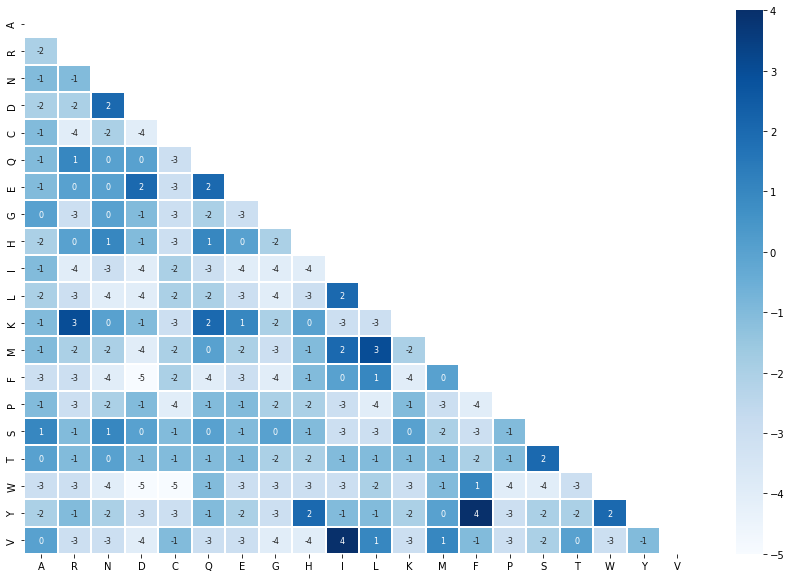

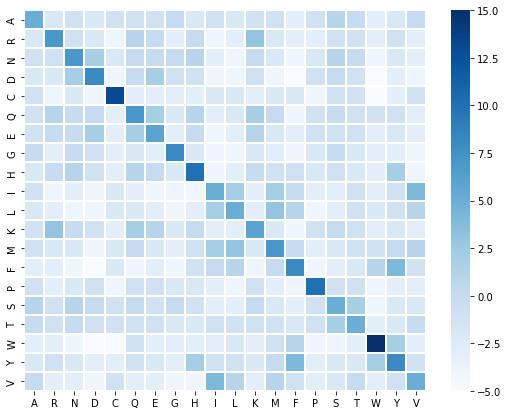

In [52]:
tbl = blosum_dict

pearson_tbl_blosum_dict = corrcoef_heatmap(tbl, columns, annot_= True, mask_=True)
pearson_tbl_blosum_dict  = corrcoef_heatmap(tbl, columns, sizex=9, sizey=7, annot_= False, mask_= False)

A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y, V, 

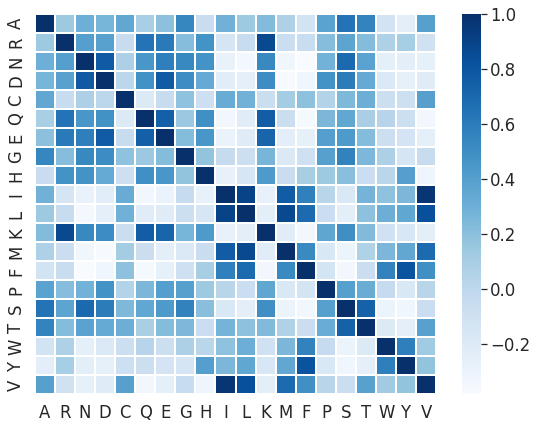

In [149]:
corrcoef = corrcoef_aas(blosum_dict, norm=None, pearson=False)

corrcoef_bl = corrcoef_heatmap(corrcoef, columns, sizex=9, sizey=7, annot_= False, mask_= False)

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,1.000000,0.139320,0.299880,0.267725,0.349168,0.087917,0.198694,0.545921,-0.060652,0.290694,0.136794,0.230067,0.063246,-0.123531,0.382439,0.642416,0.559793,-0.121487,-0.247720,0.399383
R,0.139320,1.000000,0.401080,0.384402,-0.052868,0.639378,0.608421,0.215727,0.475133,-0.148656,-0.048789,0.867175,-0.070491,-0.056794,0.213995,0.363512,0.226582,0.061899,0.101944,-0.111801
N,0.299880,0.401080,1.000000,0.776406,0.075864,0.450836,0.579537,0.529828,0.473937,-0.283057,-0.354428,0.526852,-0.326217,-0.383410,0.286481,0.693532,0.381685,-0.253979,-0.240002,-0.260702
D,0.267725,0.384402,0.776406,1.000000,0.007470,0.479753,0.770757,0.506468,0.334040,-0.227823,-0.253346,0.503957,-0.376497,-0.332668,0.473470,0.595353,0.334077,-0.183671,-0.259281,-0.215897
C,0.349168,-0.052868,0.075864,0.007470,1.000000,-0.198089,-0.049605,0.188329,-0.082199,0.320387,0.289829,-0.069447,0.110000,0.190437,0.044426,0.240264,0.307459,-0.076835,-0.090388,0.392105
Q,0.087917,0.639378,0.450836,0.479753,-0.198089,1.000000,0.744718,0.143988,0.486770,-0.345020,-0.223694,0.761267,-0.066725,-0.360433,0.253202,0.351911,0.081594,0.032042,-0.075389,-0.345411
E,0.198694,0.608421,0.579537,0.770757,-0.049605,0.744718,1.000000,0.224209,0.450154,-0.296128,-0.219730,0.716535,-0.246039,-0.261597,0.405490,0.427893,0.221839,-0.078406,-0.136303,-0.258754
G,0.545921,0.215727,0.529828,0.506468,0.188329,0.143988,0.224209,1.000000,0.175447,-0.040735,-0.076036,0.267805,-0.188329,-0.091961,0.395097,0.566529,0.245652,0.075797,-0.141856,-0.044252
H,-0.060652,0.475133,0.473937,0.334040,-0.082199,0.486770,0.450154,0.175447,1.000000,-0.277358,-0.159299,0.430582,-0.059184,0.096331,0.136334,0.208093,-0.073521,0.014436,0.404182,-0.318687
I,0.290694,-0.148656,-0.283057,-0.227823,0.320387,-0.345020,-0.296128,-0.040735,-0.277358,1.000000,0.898225,-0.276815,0.765685,0.575083,0.024023,-0.174916,0.272054,0.185184,0.252200,0.971984


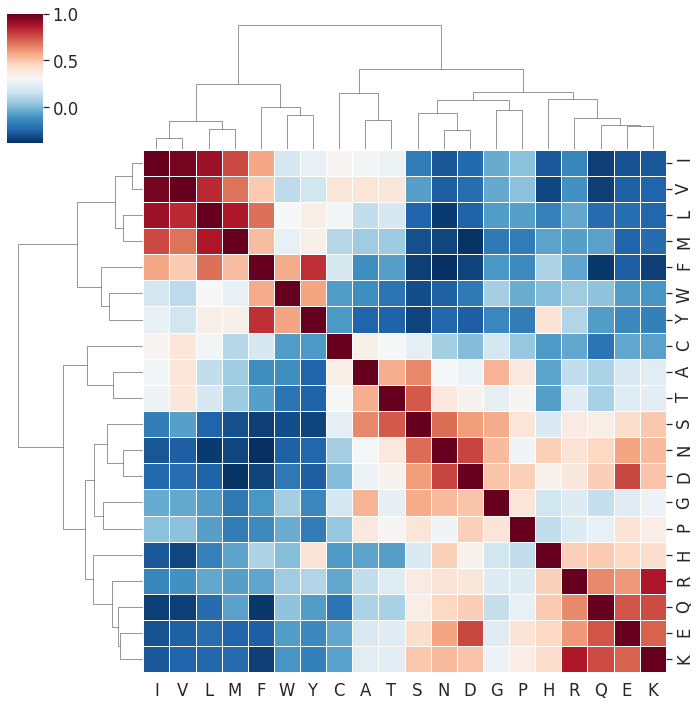

In [155]:
g = sn.clustermap(corrcoef_bl, cmap='RdBu_r', linewidths=0.5)
corrcoef_bl

In [54]:
embedding_random = np.array(pearson_tbl_R).flatten()
bl_d = np.array(list(blosum_dict.values())).flatten()
blosum_sim = np.array(pearson_tbl_blosum_dict).flatten()
embedding_only = np.array(pearson_tbl_L_100p).flatten()
#embedding_E = np.array(pearson_tbl_E_L).flatten()
embedding_100_ED64 = np.array(pearson_tbl_ED64_L).flatten()


col_names = ['emb-Random', 'BLOSUM50', 'emb-Learned', 'emb-Learned-ED_100p64'] # , 'emb-Learned-ED-200' ]

sim_list = [embedding_random, blosum_sim, embedding_only, embedding_100_ED64] #, embedding_ED200]


def similariy_matrix_models(a, b):
    coef = np.corrcoef(a, b)[0][1]
    return coef

matrix_1 = []
for i in sim_list:
    matrix_2 = []
    for t in sim_list:
        matrix_2.append(similariy_matrix_models(i, t))
    matrix_1.append(matrix_2)

sim = pd.DataFrame(matrix_1, columns = col_names)
sim.index = col_names
sim

,emb-Random,BLOSUM50,emb-Learned,emb-Learned-ED_100p64
emb-Random,1.000000,0.478095,0.529646,0.600077
BLOSUM50,0.478095,1.000000,0.843384,0.850293
emb-Learned,0.529646,0.843384,1.000000,0.913792
emb-Learned-ED_100p64,0.600077,0.850293,0.913792,1.000000


### Calculate HLA specific AUC of models:

In [56]:
df = df_pd_nested_test_unique.reset_index(drop=True)
HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

In [57]:
HLA_perf = []
for HLA in HLA_list:
    temp = df[df['HLA']==HLA]
    auc_ = roc_auc_score(temp['target_'], temp['pred_'])

    num_pos = len(temp[temp['target_']==1])
    df_temp_ppv = temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
    num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
    ppv = num_true_pos/num_pos
    auc_01 = fnc.binary_roc_auc_score(temp['target_'].tolist(), temp['pred_'].tolist(), max_fpr=0.1)
    HLA_perf.append([HLA, auc_, auc_01, ppv])
    
HLA_perf_df = pd.DataFrame(HLA_perf, columns = ['HLA', 'AUC', 'AUC01', 'PPV'])  
HLA_perf_df.sort_values(by = ['HLA'])

,HLA,AUC,AUC01,PPV
107,HLA-A*01:01,0.990278,0.925010,0.909874
85,HLA-A*02:01,0.959779,0.765130,0.809803
106,HLA-A*02:02,0.957063,0.652882,0.760479
82,HLA-A*02:03,0.968240,0.752320,0.805688
41,HLA-A*02:04,0.988375,0.926457,0.916168
...,...,...,...,...
16,HLA-C*12:03,0.989909,0.902149,0.896104
0,HLA-C*14:02,0.996154,0.963138,0.951498
35,HLA-C*15:02,0.990139,0.905186,0.897050
8,HLA-C*16:01,0.988315,0.889573,0.889723


In [ ]:
df.to_csv('{}_perf.csv'.format(id_nested)) 
HLA_perf_df.to_csv('{}_HLAperf.csv'.format(id_nested))  
print(id_nested)

## Charged embedding AA similarity

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
def corrcoef_perAA(repr_dict, aa_vec):
    X = aa_vec
    tbl = []
    for aa_c in repr_dict.keys():
        Y = repr_dict[aa_c]
        pearson = np.corrcoef(X, Y)[0][1] 
        tbl.append(pearson)
        
    return tbl

def prepare_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, aa_):
    
    df_list = []
    
    id_ = ['LE Baseline', 'LE Attention', 'BLOSUM']
    id_x = 0
    
    for dd in [embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict]:

        barp = corrcoef_perAA(dd, dd[aa_])  

        df_barp_ed = pd.DataFrame(barp, columns=['Similarity score'])
        df_barp_ed.index = dd.keys()
        df_barp_ed['Amino Acid'] = df_barp_ed.index
        df_barp_ed['Method'] = id_[id_x]
        df_list.append(df_barp_ed)
        
        id_x += 1
    df_concat = pd.concat(df_list, axis=0)
    return df_concat


def draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, aa_):
    
    df_concat = prepare_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, aa_)
    sns.set(rc = {'figure.figsize':(10,5)})
    #set seaborn plotting aesthetics
    sns.set(style='white')

    #create grouped bar chart
    sns.barplot(x='Amino Acid', y='Similarity score', hue='Method', data=df_concat, palette = 'GnBu')

    for ax in plt.gcf().axes:
        plt.setp(ax.get_legend().get_texts(), fontsize=11)  # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize=11)  # for legend title

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=22)

    for ax in plt.gcf().axes:
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=22)

    sn.set(font_scale=1.5)

    sn.despine(offset=10, trim=True)
    print(aa_)


D


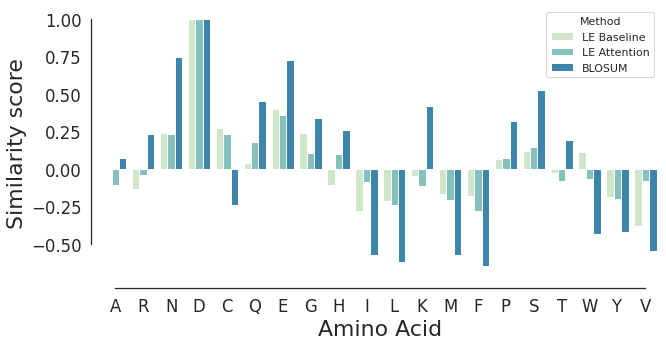

In [84]:
draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'D')

E


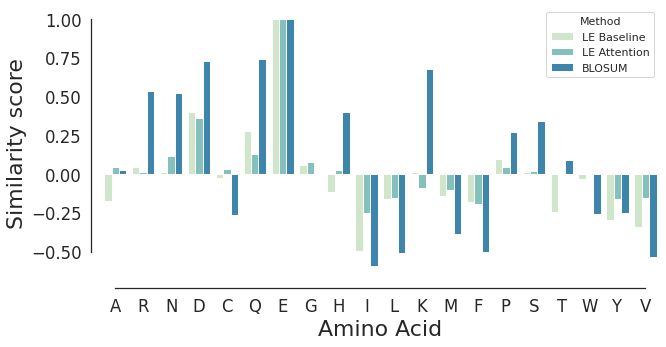

In [85]:
draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'E')

H


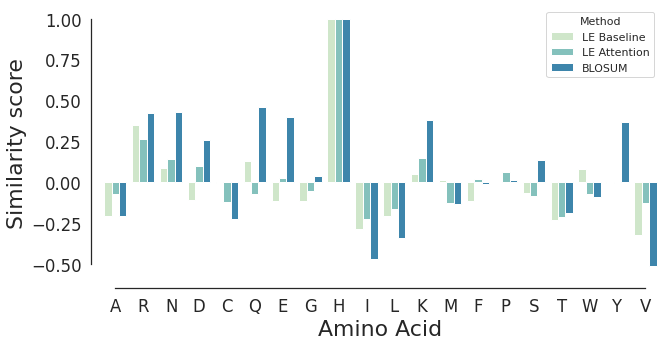

In [86]:
draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'H')

K


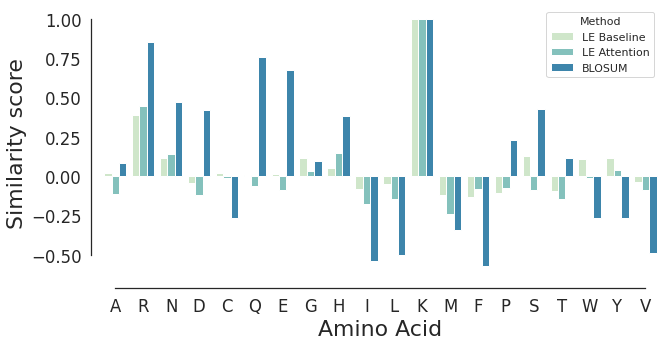

In [87]:
draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'K')

R


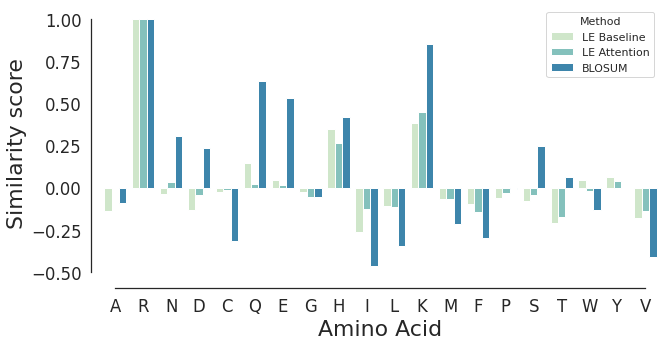

In [88]:
draw_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'R')

In [90]:
df_concat = prepare_corrcoef_perAA(embedding_dict_100p, embedding_dict_100p_ED_learned_64, blosum_dict, 'K')
df_concat[df_concat['Amino Acid']=='K']

,Similarity score,Amino Acid,Method
K,1.0,K,LE Baseline
K,1.0,K,LE Attention
K,1.0,K,BLOSUM
